In [41]:
# imports
import math
import pandas as pd
from IPython import display
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
from tensorflow.python.data import Dataset
from tensorflow.keras import layers

In [42]:
def construct_feature_columns():
    bucketized_prefix = tf.feature_column.categorical_column_with_vocabulary_list(
        key="prefix",
        vocabulary_list=["bazelci/", "examples/", "scripts/", "site/", "src/conditions", "src/java_tools", "src/main", "src/test", "src/tools", "third_party/", "tools/"],
        num_oov_buckets=11)
    print(bucketized_prefix)
    bucketized_type = tf.feature_column.categorical_column_with_vocabulary_list(
        key="type",
        vocabulary_list=["JAVA", "C/C++", "Starlark", "python", "HTML/CSS/JS"], num_oov_buckets=5)
    print(bucketized_type)
    prefix_x_type = tf.feature_column.crossed_column(set([bucketized_prefix, bucketized_type]), hash_bucket_size=1000)
    feature_columns = set([
        bucketized_prefix,
        bucketized_type,
        prefix_x_type,
    ])
    return feature_columns

In [32]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # convert pandas data into a dict of np arrays
    features = {key: np.array(value) for key, value in dict(features).items()}

    # construct a dataset, and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))  # beware of limits
    ds = ds.batch(batch_size).repeat(num_epochs)

    # shuffle the data, if specified
    if shuffle:
        ds = ds.shuffle(10000)

    # returns the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [33]:
# training linear regression model


def train_model(learning_rate, steps, batch_size, feature_columns, training_examples, training_targets,
                validation_examples, validation_targets):
                
    periods = 10
    steps_per_period = steps / periods

    # create a linear regressor object
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns, optimizer='SGD')

    def training_input_fn(): return my_input_fn(training_examples, training_targets['CPUTime'],
                                                batch_size=batch_size)

    def predict_training_input_fn(): return my_input_fn(training_examples, training_targets['CPUTime'],
                                                        num_epochs=1, shuffle=False)

    def predict_validation_input_fn(): return my_input_fn(validation_examples, validation_targets['CPUTime'],
                                                          num_epochs=1, shuffle=False)

    # train the model but do so inside a loop so that we can periodically assess loss metrics
    print('Training model...')
    print('RMSE (on training data):')
    training_rmse = []
    validation_rmse = []

    for period in range(0, periods):
        # train the model, starting from prior state
        linear_regressor.train(
            input_fn=training_input_fn, steps=steps_per_period)

        # take a break and compute predictions
        training_predictions = linear_regressor.predict(
            input_fn=predict_training_input_fn)
        training_predictions = np.array(
            [item['predictions'][0] for item in training_predictions])

        validation_predictions = linear_regressor.predict(
            input_fn=predict_validation_input_fn)
        validation_predictions = np.array(
            [item['predictions'][0] for item in validation_predictions])

        # compute training and validation loss
        
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))

        # occasionally print the current loss
        print(' period %02d: %0.2f' %
              (period, training_root_mean_squared_error))

        # add the loss metrics from this period to our list
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print('Model training finished')

    # output to a graph of loss metris over periods
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error vs. Periods')
    plt.tight_layout()
    plt.plot(training_rmse, label='training')
    plt.plot(validation_rmse, label='validation')
    plt.ylim([0, 10000])
    plt.legend()
    plt.show()
    
    return linear_regressor


In [34]:
def test_model(learning_rate, steps, batch_size, feature_columns, testing_examples, testing_targets):
    
    periods = 10
    steps_per_period = steps / periods

    # create a linear regressor object
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns, optimizer='Ftrl')

    def testing_input_fn(): return my_input_fn(testing_examples, testing_targets['CPUTime'],
                                                batch_size=batch_size)

    def predict_testing_input_fn(): return my_input_fn(testing_examples, testing_targets['CPUTime'],
                                                        num_epochs=1, shuffle=False)


    # test the model
    print('Testimg model...')
    print('RMSE (on testing data):')
    testing_rmse = []

    for period in range(0, periods):
        # take a break and compute predictions
        testing_predictions = linear_regressor.predict(
            input_fn=predict_testing_input_fn)
        testing_predictions = np.array(
            [item['predictions'][0] for item in testing_predictions])

        # compute testing loss
        testing_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(testing_predictions, testing_targets))

        # occasionally print the current loss
        print(' period %02d: %0.2f' %
              (period, testing_root_mean_squared_error))

        # add the loss metrics from this period to our list
        testing_rmse.append(testing_root_mean_squared_error)
    print('Model testing finished')

    # output to a graph of loss metris over periods
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error vs. Periods')
    plt.tight_layout()
    plt.plot(testing_rmse, label='testing')
    plt.ylim([0, 10000])
    plt.legend()
    plt.show()
    
    return linear_regressor


Training examples summary:


,ID,prefix,type
count,300,300,300
unique,300,8,4
top,b0102b689,src/main,JAVA
freq,1,114,252


Validation examples summary:


,ID,prefix,type
count,100,100,100
unique,100,6,3
top,b55e4043a,src/main,JAVA
freq,1,38,86


Testing examples summary:


,ID,prefix,type
count,100,100,100
unique,100,6,3
top,b4871d59b,tools/,JAVA
freq,1,36,89


Training targets summary:


,CPUTime
count,300.000000
mean,4208.560000
std,5582.824356
min,564.000000
25%,854.250000
50%,1800.500000
75%,4548.250000
max,44863.000000


Validation targets summary:


,CPUTime
count,100.000000
mean,4033.950000
std,5394.638939
min,566.000000
25%,690.500000
50%,1874.500000
75%,5348.250000
max,37113.000000


Testing targets summary:


,CPUTime
count,100.00000
mean,4707.07000
std,5815.15473
min,571.00000
25%,809.50000
50%,1975.00000
75%,6913.75000
max,27056.00000


VocabularyListCategoricalColumn(key='prefix', vocabulary_list=('bazelci/', 'examples/', 'scripts/', 'site/', 'src/conditions', 'src/java_tools', 'src/main', 'src/test', 'src/tools', 'third_party/', 'tools/'), dtype=tf.string, default_value=-1, num_oov_buckets=11)
VocabularyListCategoricalColumn(key='type', vocabulary_list=('JAVA', 'C/C++', 'Starlark', 'python', 'HTML/CSS/JS'), dtype=tf.string, default_value=-1, num_oov_buckets=5)
VocabularyListCategoricalColumn(key='prefix', vocabulary_list=('bazelci/', 'examples/', 'scripts/', 'site/', 'src/conditions', 'src/java_tools', 'src/main', 'src/test', 'src/tools', 'third_party/', 'tools/'), dtype=tf.string, default_value=-1, num_oov_buckets=11)
VocabularyListCategoricalColumn(key='type', vocabulary_list=('JAVA', 'C/C++', 'Starlark', 'python', 'HTML/CSS/JS'), dtype=tf.string, default_value=-1, num_oov_buckets=5)
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Lenovo\\AppData\\Local\\Temp\\tmpm23u

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt-150
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
 period 02: 5714.44
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt-150
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 150...
INFO:tensorflow:Saving checkpoints for 150 into C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt.
INFO:tensorflow:C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt-150.data-00000-of-00001
INFO:tensorflow:0
INFO:tensorflow:C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt-15

INFO:tensorflow:0
INFO:tensorflow:C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt-350.meta
INFO:tensorflow:200
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 350...
INFO:tensorflow:Loss for final step: 36854450.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt-350
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Lenovo\AppData\Local\Temp\tmpm23u8fik\model.ckpt-350
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
 period 06: 5436.82
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph w

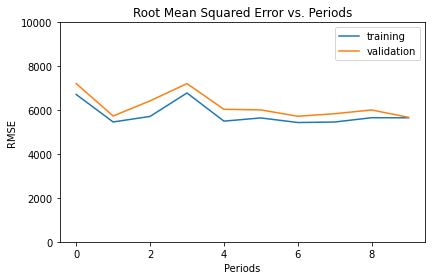

VocabularyListCategoricalColumn(key='prefix', vocabulary_list=('bazelci/', 'examples/', 'scripts/', 'site/', 'src/conditions', 'src/java_tools', 'src/main', 'src/test', 'src/tools', 'third_party/', 'tools/'), dtype=tf.string, default_value=-1, num_oov_buckets=11)
VocabularyListCategoricalColumn(key='type', vocabulary_list=('JAVA', 'C/C++', 'Starlark', 'python', 'HTML/CSS/JS'), dtype=tf.string, default_value=-1, num_oov_buckets=5)
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Lenovo\\AppData\\Local\\Temp\\tmpv9dd0vcq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': N

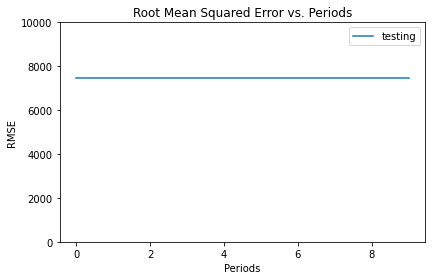

In [35]:
# main function
if __name__ == '__main__':
    # sort input data
    InputData = pd.read_csv('InputData.csv', sep=',')
    training_examples = InputData.head(300)
    validation_examples = InputData.loc[301:400]
    testing_examples = InputData.tail(100)

    # sort target data
    CPUTimes = pd.read_csv('CPUTimes.csv', sep=',')
    CPUTimes = CPUTimes[["CPUTime"]]
    training_targets = CPUTimes.head(300)
    validation_targets = CPUTimes.loc[301:400]
    testing_targets = CPUTimes.tail(100)

    # visualize sorted input data
    print('Training examples summary:')
    display.display(training_examples.describe())
    print('Validation examples summary:')
    display.display(validation_examples.describe())
    print('Testing examples summary:')
    display.display(testing_examples.describe())

    # visualize sorted target data
    print('Training targets summary:')
    display.display(training_targets.describe())
    print('Validation targets summary:')
    display.display(validation_targets.describe())
    print('Testing targets summary:')
    display.display(testing_targets.describe())

    construct_feature_columns()
    # train a linear regression model
    
    train_model(
        learning_rate=1.0,
        steps=500,
        batch_size=16,
        feature_columns=construct_feature_columns(),
        training_examples=training_examples,
        training_targets=training_targets,
        validation_examples=validation_examples,
        validation_targets=validation_targets)

    test_model(
        learning_rate=1.0,
        steps=500,
        batch_size=16,
        feature_columns=construct_feature_columns(),
        testing_examples=testing_examples,
        testing_targets=testing_targets)


<function matplotlib.pyplot.show(close=None, block=None)>

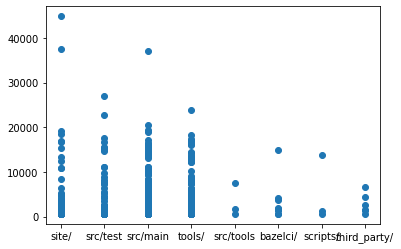

In [36]:
plt.scatter(InputData["prefix"], CPUTimes["CPUTime"])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

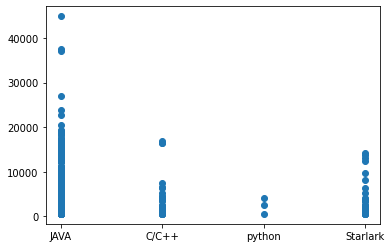

In [37]:
plt.scatter(InputData["type"], CPUTimes["CPUTime"])
plt.show

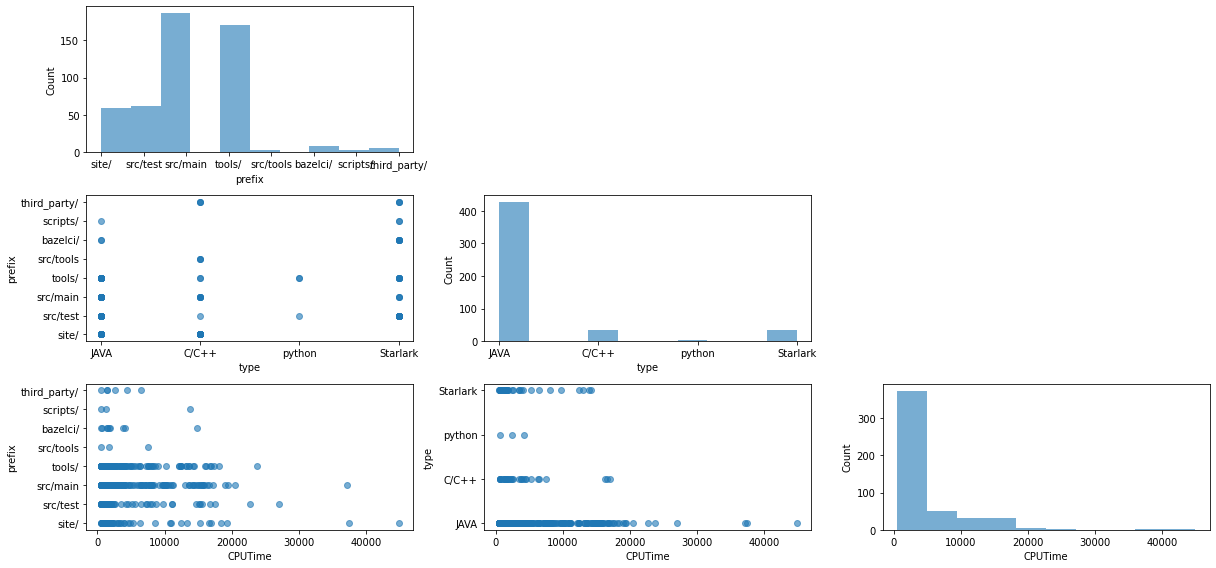

In [38]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
df = pd.read_csv('CPUTimes_inputdata.csv')
cols = ['prefix', 'type' ,'CPUTime']
scatterplotmatrix(df[cols].values, figsize =(17,8) , names = cols , alpha =0.6)
plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testing_predictions, testing_targets)
cm

NameError: name 'testing_predictions' is not defined